<a href="https://colab.research.google.com/github/brentosaurus/fastbook/blob/master/01_intro%20(modified).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up all libraries

In [ ]:
!pip install -Uqq fastai duckduckgo_search
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

## Delete all files, so files from the last run don't contaminate this run

In [ ]:
!rm -r *

## Download several of each type of image

In [ ]:
#things = ['thomas cole painting', 'turner painting']
#things = ['jack kirby original art', 'steve ditko original art']
#things = ['Frederic Edwin Church painting', 'Albert Bierstadt painting']
things = ['hot dog', 'hamburger', 'pizza', 'steak']
#things = ['cynthia hamilton painting', 'john singer sargent painting']

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    result = L(ddg_images(term, max_results=max_images)).itemgot('image')
    #print(result)
    return result

path = Path('art')
for thing in things:
    destPath = (path/thing)
    destPath.mkdir(exist_ok=True, parents=True)
    download_images(destPath, urls=search_images(thing))
    sleep(2)
    resize_images(destPath, max_size=400, dest=destPath)

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print('--- failed images:', len(failed))

Searching for 'hot dog'
Searching for 'hamburger'


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'pizza'
Searching for 'steak'
--- failed images: 3


## Set up the AI magic, based on these images

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.938984,1.050857,0.380952,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.813289,0.533391,0.190476,00:01
1,0.460854,0.225603,0.095238,00:00
2,0.352444,0.154617,0.047619,00:00


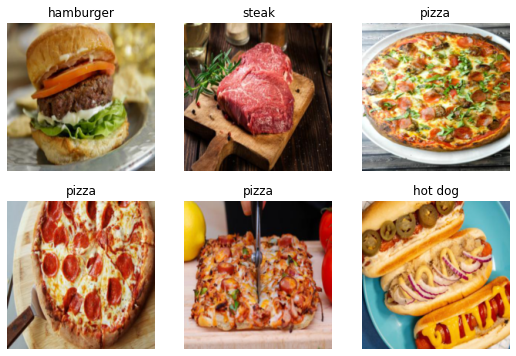

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=16) # WAS 32

dls.show_batch(max_n=6)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

## Download some more images, to see how well the AI works

Searching for 'hot dog'


Searching for 'hamburger'


Searching for 'pizza'


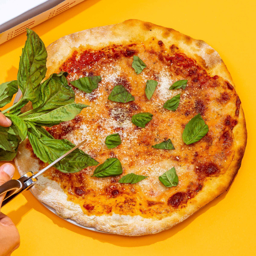

This is a: hamburger, probabilities: [0.66, 0.06, 0.27, 0.0]  (WRONG!)

Searching for 'steak'


15 right, 1 wrong


In [ ]:
#@title
import math

right = wrong = 0
show_all = False        # if False then only show wrong answers
for thing in things:
    urls = search_images(thing, max_images=4)
    #print(urls)

    for url in urls:
        #print('testing', url)
        download_url(url, 'test.jpg', show_progress=False)
        category,_,probs = learn.predict(PILImage.create('test.jpg'))
        if show_all or category != thing:
            display(Image.open('test.jpg').to_thumb(256, 256))
            print(f"This is a: {category}, probabilities: {[round(float(ff),2) for ff in probs]} {'' if category == thing else ' (WRONG!)'}\n")

        if category == thing:
            right += 1
        else:
            wrong += 1

print(f'{right} right, {wrong} wrong')